# Preliminary support for predictive coding  

If inhibitory interneurons subtract a prediction of ganglion firing, we should expect higher correlations between the ganglion cells and connected inhibitory interneurons if we were able to silence inhibitory communication to the ganglion cells (but not alter the inhibitory membrane potential).  

We can essentially do this with intracellular record & playback experiments. This notebook will analyze some of David Kastner's record & playback data to determine if the correlations between ganglion cells and amacrine cells is what we'd expect when inhibition is amplified or diminished.

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import sem, pearsonr
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Predictive Coding Correlation Experiments/')

### Load ganglion cell spiking and inhibitory interneuron membrane potential  
ganglion is cell array of which playback experiment (0,1,2) >> which cell (0, ..., 13) >> which spike timestamp  
surround is cell array of which playback experiment (0,1,2) >> membrane potential

In [4]:
ganglion_files = ['012514_ganglions_0.mat','012514_ganglions_1.mat','012514_ganglions_2.mat']
surround_files = ['012514_c1_s0_0_300.txt','012514_c1_s1_0_300.txt','012514_c1_s2_0_300.txt']

ganglion = []
surround = []

# load ganglion cell spiking files
for g_file in ganglion_files:
    tmp = scipy.io.loadmat(data_dir + g_file, squeeze_me=True)
    cells = [tmp['spikes'][:,c][tmp['spikes'][:,c] > 0] for c in range(tmp['spikes'].shape[1])]
    ganglion.append(cells)
    
# load surround membrane potential
for s_file in surround_files:
    tmp = np.loadtxt(data_dir + s_file, dtype='float', skiprows=1)
    surround.append(tmp)

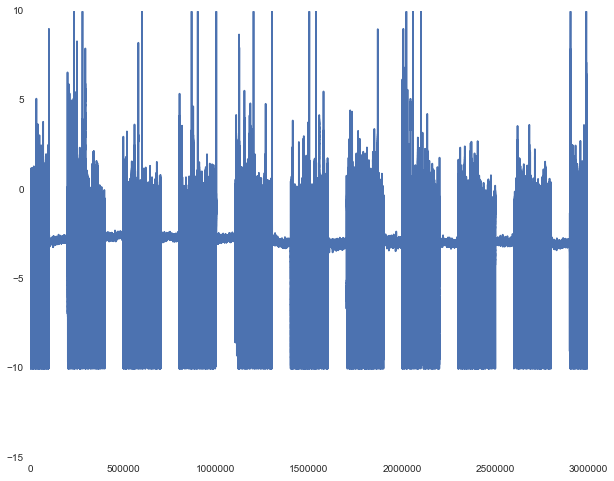

In [5]:
plot(surround[0])

## Copy Table0:info conditions information 

### According to conversation with David, 0-1 is control, 2-3 is amplify, and 4-5 is diminish for 1/25/14 experiment, whereas 0-1 is control, 2-3 is diminish, 4-5 is amplify for 4/4/12 experiment.  

### From the firing rate plot below however, it must always be 0-1 control, 2-3 diminish, 4-5 amplify.

In [6]:
control_time = [[10.5, 20.], [0.5, 10.], [20.5, 30.]]
amplify_time = [[0.5, 10.], [20.5, 30.], [10.5, 20.]]
diminish_time = [[20.5, 30.], [10.5, 20.], [0.5, 10.]]

# Look at ganglion firing rates in the amplify, diminish, and control conditions

In [7]:
num_seconds = 0.95*300./3
control_firing_rate = []
amplify_firing_rate = []
diminish_firing_rate = []
for idp, playback in enumerate(ganglion):
    for idc, cell in enumerate(playback):
        ctrl = [spike for spike in cell if spike % 30 > control_time[idp][0] and spike % 30 < control_time[idp][1]]
        amp  = [spike for spike in cell if spike % 30 > amplify_time[idp][0] and spike % 30 < amplify_time[idp][1]]
        dim  = [spike for spike in cell if spike % 30 > diminish_time[idp][0] and spike % 30 < diminish_time[idp][1]]
        control_firing_rate.append(len(ctrl)/num_seconds)
        amplify_firing_rate.append(len(amp)/num_seconds)
        diminish_firing_rate.append(len(dim)/num_seconds)
        
firing_rates = np.array([control_firing_rate, amplify_firing_rate, diminish_firing_rate]).T
relative_firing_rates = 100. * ((firing_rates.T - control_firing_rate)/control_firing_rate).T # percent firing increase/decrease

# Average increase/decrease in relative firing rates

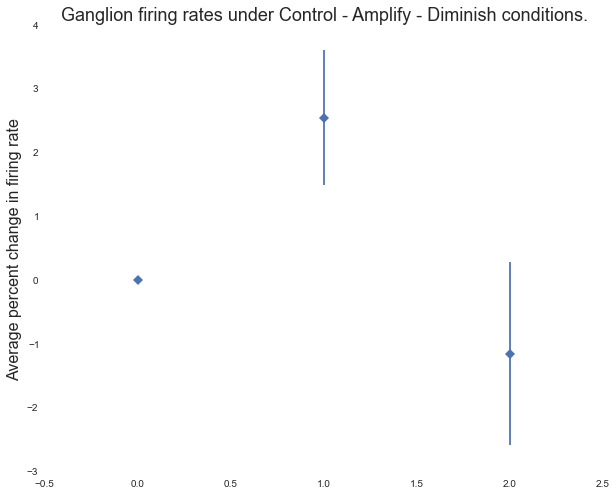

In [9]:
frs = np.mean(relative_firing_rates, axis=0)
sems = sem(relative_firing_rates)
errorbar([0, 1, 2], frs, yerr=sems, fmt='D')
xlim([-.5, 2.5])
title('Ganglion firing rates under Control - Amplify - Diminish conditions.', fontsize=18)
ylabel('Average percent change in firing rate', fontsize=16)

# Compute correlations

## Correlations:  
- Control ganglion cell & control amacrine cell  
- Diminished ganglion cell & control amacrine cell  
- Amplified ganglion cell & control amacrine cell  

Need to control for visual stimulus, so will need to compute correlation across different 300s playback trials

In [10]:
sample_rate = len(surround[0])/300.
block_time = np.linspace(0,9.5,9.5 * sample_rate)    # time per trial subblock
trial_time = np.linspace(0,300,len(surround[0]))

### Correlation between control and control (this has to be within-trial)

In [11]:
num_trials = 10
control_control_corrs = {}    # let control_control_corrs be a dictionary of correlations for each cell
for playback in range(3):
    # a slight fudge to make sure each playback control trial has the same number of indices
    if playback != 2:
        eps = 0.0
    else:
        eps = 10e-6
        
    # bin spikes
    spiking = []
    for cell in ganglion[playback]:
        spiking.append(pyret.spiketools.binspikes(cell, time=trial_time)[0])
    
    # make list of 0's and 1's corresponding to if in a control period
    ctrl_inds = [ind for ind,t in enumerate(trial_time) if t % 30 >= control_time[playback][0] - eps and t % 30 <= control_time[playback][1]]
    ctrl_blocks = np.array(ctrl_inds).reshape((num_trials, len(ctrl_inds)/num_trials))
    
    # compute correlation for each block
    for block in range(num_trials):
        # compute inhibition for each block
        ctrl_inhibition = surround[playback][ctrl_blocks[block]]
    
        # store correlation in a per-cell dictionary
        for cell in range(len(ganglion[playback])):
            if cell in control_control_corrs.keys():
                control_control_corrs[cell].append(pearsonr(ctrl_inhibition, spiking[cell][ctrl_blocks[block]])[0])
            else:
                control_control_corrs[cell] = [pearsonr(ctrl_inhibition, spiking[cell][ctrl_blocks[block]])[0]]

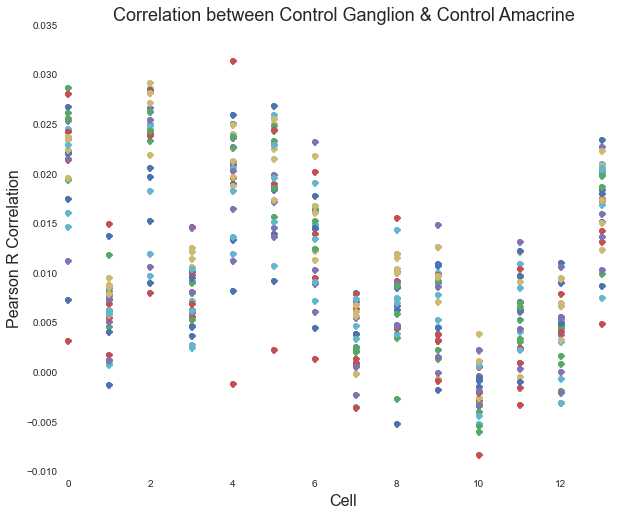

In [12]:
p = plot(control_control_corrs.values(), 'o')
x = xlim([-0.1, 13.5])
title('Correlation between Control Ganglion & Control Amacrine', fontsize=18)
xlabel('Cell', fontsize=16)
ylabel('Pearson R Correlation', fontsize=16)

#### What are we comparing for the correlation?  
We are comparing each 9.5 second block of ganglion spiking and amacrine membrane potential for all 3 playbacks.

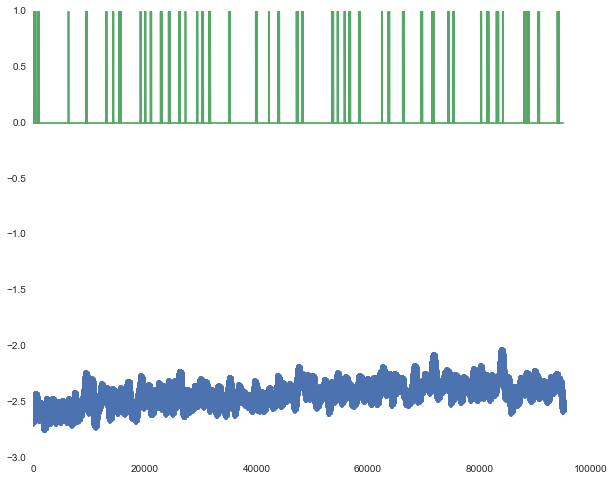

In [13]:
plot(ctrl_inhibition, 'o')
plot(spiking[cell][ctrl_blocks[block]])

### Okay, now compute correlations for diminish/control and amplify/control conditions  
This will need to be across different playbacks.

In [14]:
# bin spikes for all playback conditions and all cells. spiking[playback][cell]
spiking = []
for playback in range(3):
    spiking.append([pyret.spiketools.binspikes(cell, time=trial_time)[0] for cell in ganglion[playback]])
    
num_cells = len(ganglion[0])
num_blocks = 10
amplify_control_corrs = {}    # let control_control_corrs be a dictionary of correlations for each cell
diminish_control_corrs = {}    # let control_control_corrs be a dictionary of correlations for each cell
for playback in range(3):
    # a slight fudge to make sure each playback control trial has the same number of indices
    if playback != 2:
        eps = 0.0
    else:
        eps = 10e-6
    
    # make list of 0's and 1's corresponding to if in a control period
    ctrl_inds = [ind for ind,t in enumerate(trial_time) if t % 30 >= control_time[playback][0] - eps and t % 30 <= control_time[playback][1]]
    ctrl_blocks = np.array(ctrl_inds).reshape((num_blocks, len(ctrl_inds)/num_blocks))
    
    # need to determine which playback has the diminished amacrine cell, and which has the amplified amacrine 
    # cell during the ctrl_blocks of the current playback. We should just need to do this for one block, since
    # the blocks repeat regularly with the same frequency across playbacks.
    for p in range(3):
        # we look at the second timestamp of the first ctrl block to determine which playback is amplified
        # or diminished during that time
        if trial_time[ctrl_blocks[0, 1]] > amplify_time[p][0] and trial_time[ctrl_blocks[0, 1]] < amplify_time[p][1]:
            amplify_playback = p
        if trial_time[ctrl_blocks[0, 1]] > diminish_time[p][0] and trial_time[ctrl_blocks[0, 1]] < diminish_time[p][1]:
            diminish_playback = p
    
    # compute correlation for each block
    for block in range(num_blocks):
        # compute inhibition for each block
        ctrl_inhibition = surround[playback][ctrl_blocks[block]]
    
        # store correlation in a per-cell dictionary
        for cell in range(num_cells):
            # Store amplify/control correlations
            if cell in amplify_control_corrs.keys():
                amplify_control_corrs[cell].append(pearsonr(ctrl_inhibition, 
                                                            spiking[amplify_playback][cell][ctrl_blocks[block]])[0])
            else:
                amplify_control_corrs[cell] = [pearsonr(ctrl_inhibition, 
                                                        spiking[amplify_playback][cell][ctrl_blocks[block]])[0]]
                
            if cell in diminish_control_corrs.keys():
                diminish_control_corrs[cell].append(pearsonr(ctrl_inhibition, 
                                                            spiking[diminish_playback][cell][ctrl_blocks[block]])[0])
            else:
                diminish_control_corrs[cell] = [pearsonr(ctrl_inhibition, 
                                                        spiking[diminish_playback][cell][ctrl_blocks[block]])[0]]

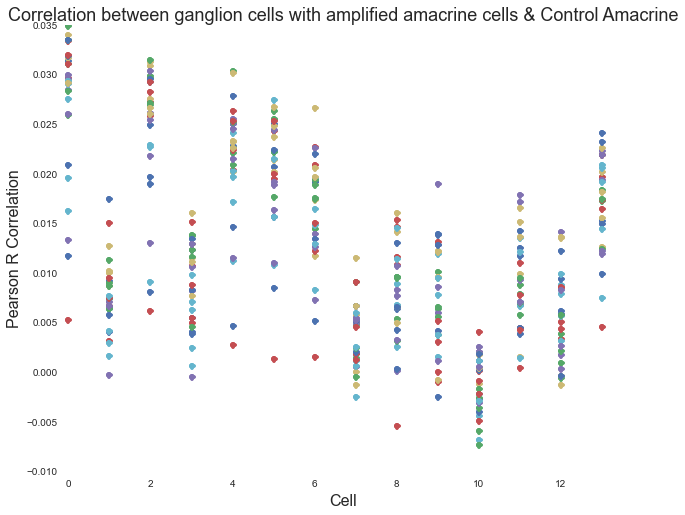

In [15]:
p = plot(amplify_control_corrs.values(), 'o')
x = xlim([-0.1, 13.5])
title('Correlation between ganglion cells with amplified amacrine cells & Control Amacrine', fontsize=18)
xlabel('Cell', fontsize=16)
ylabel('Pearson R Correlation', fontsize=16)

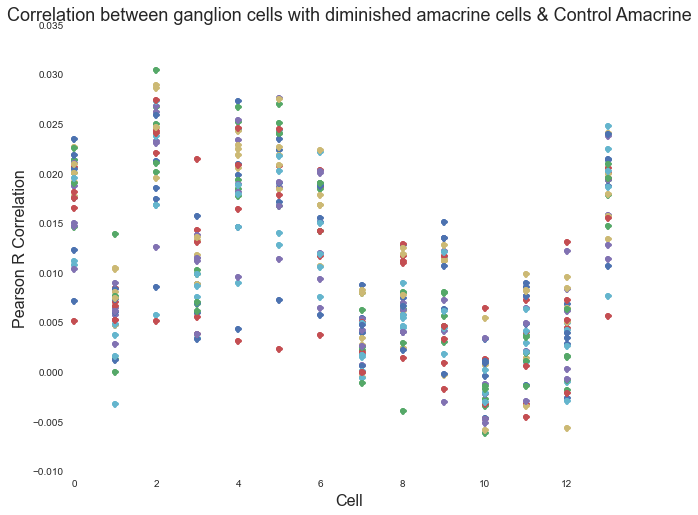

In [16]:
p = plot(diminish_control_corrs.values(), 'o')
x = xlim([-0.1, 13.5])
title('Correlation between ganglion cells with diminished amacrine cells & Control Amacrine', fontsize=18)
xlabel('Cell', fontsize=16)
ylabel('Pearson R Correlation', fontsize=16)

# Our hypothesis is that the diminish-control correlations should be larger than control-control correlations, since the prediction of ganglion spiking is not being subtracted from the ganglion cells.  

It's possible amplify-control correlations would be larger than control-control correlations if the amplification is just messing up the prediction being subtracted, otherwise it could result in smaller correlations than control-control if the amacrine prediction is not being completely subtracted in the control case.

In [17]:
mean_correlations = np.zeros((num_cells, 3))
for cell in range(num_cells):
    # get mean of control-control correlations for this cell
    mean_correlations[cell, 0] = np.mean(control_control_corrs[cell])
    # get mean of amplify-control correlations for this cell
    mean_correlations[cell, 1] = np.mean(amplify_control_corrs[cell])
    # get mean of diminish-control correlations for this cell
    mean_correlations[cell, 2] = np.mean(diminish_control_corrs[cell])
    
# delete cell 11 (index 10) because of low firing rates
mean_correlations = np.delete(mean_correlations, 10, axis=0)
    
cell_corr_control = mean_correlations[:,0]
relative_corrs = 100. * ((mean_correlations.T - cell_corr_control)/cell_corr_control).T # percent firing increase/decrease

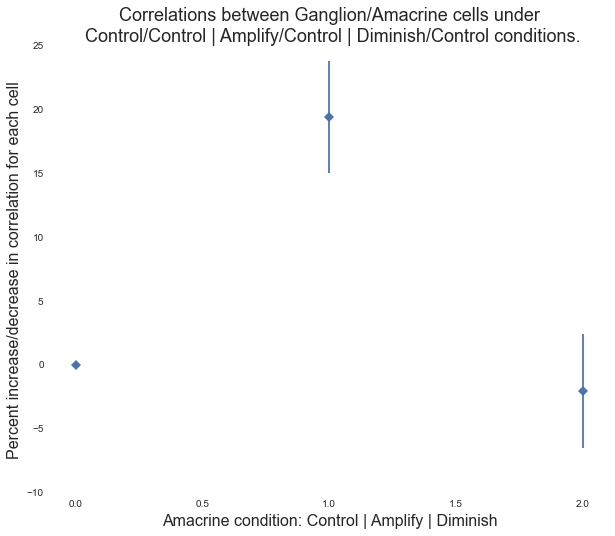

In [19]:
avg_relative_corrs = np.mean(relative_corrs, axis=0)
sems = sem(relative_corrs)
errorbar([0, 1, 2], avg_relative_corrs, yerr=sems, fmt='D')
x = xlim([-0.1, 2.1])
title('Correlations between Ganglion/Amacrine cells under \n Control/Control | Amplify/Control | Diminish/Control conditions.', fontsize=18)
xlabel('Amacrine condition: Control | Amplify | Diminish', fontsize=16)
ylabel('Percent increase/decrease in correlation for each cell', fontsize=16)

In [20]:
sem(relative_corrs)

array([ 0.        ,  4.40273633,  4.46143207])

# What about instead of percent increase/decrease, what's the average change in abs(correlation)?

In [23]:
mean_correlations = np.zeros((num_cells, 3))
for cell in range(num_cells):
    # get mean of control-control correlations for this cell
    mean_correlations[cell, 0] = np.mean(abs(np.array(control_control_corrs[cell])))
    # get mean of amplify-control correlations for this cell
    mean_correlations[cell, 1] = np.mean(abs(np.array(amplify_control_corrs[cell])))
    # get mean of diminish-control correlations for this cell
    mean_correlations[cell, 2] = np.mean(abs(np.array(diminish_control_corrs[cell])))
    
# delete cell 11 (index 10) because of low firing rates
mean_correlations = np.delete(mean_correlations, 10, axis=0)
    
cell_corr_control = mean_correlations[:,0]
diff_corrs = ((mean_correlations.T - cell_corr_control)).T # percent firing increase/decrease

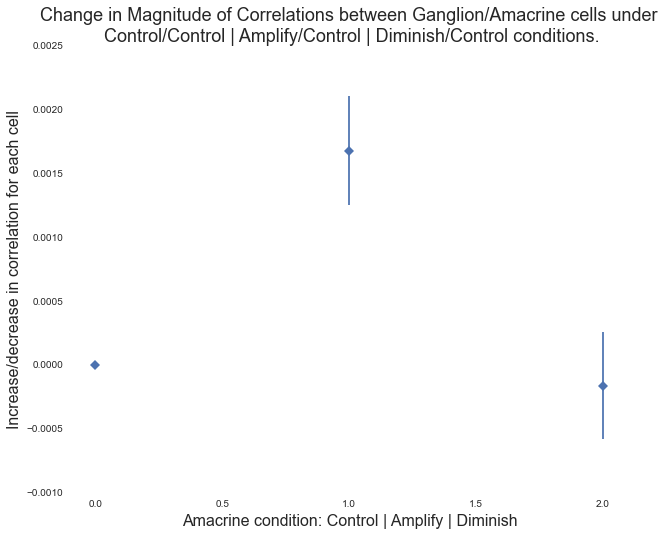

In [26]:
avg_diff_corrs = np.mean(diff_corrs, axis=0)
sems = sem(diff_corrs)
errorbar([0, 1, 2], avg_diff_corrs, yerr=sems, fmt='D')
x = xlim([-0.1, 2.1])
title('Change in Magnitude of Correlations between Ganglion/Amacrine cells under \n Control/Control | Amplify/Control | Diminish/Control conditions.', fontsize=18)
xlabel('Amacrine condition: Control | Amplify | Diminish', fontsize=16)
ylabel('Increase/decrease in correlation for each cell', fontsize=16)